
# Zoom (ZM) — Earnings Impact Analysis 

**Objective.** Analyze how quarterly earnings announcements relate to **short‑horizon returns** and **volatility** for Zoom (ZM) using a **static price CSV** (from Kaggle) and a **manually curated earnings CSV**. This notebook is intentionally simple and reproducible — no live APIs.

**What you'll see after each code block:** a figure or analytics output.

---


In [1]:

# Imports & project configuration
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: statsmodels for a simple OLS check (non-causal association)
try:
    import statsmodels.api as sm
    HAS_SM = True
except Exception as e:
    HAS_SM = False

# Optional: scipy for Welch's t-test; if not available, we'll skip that cell gracefully
try:
    from scipy import stats
    HAS_SCIPY = True
except Exception as e:
    HAS_SCIPY = False

# Paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
TABLEAU_DIR = PROJECT_ROOT / "tableau"

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
TABLEAU_DIR.mkdir(parents=True, exist_ok=True)

# File discovery with sensible defaults and fallbacks
PRICE_FILE_CANDIDATES = [
    DATA_DIR / "zm_prices.csv",
    DATA_DIR / "Zoom_stocks.csv",
    DATA_DIR / "zoom_stocks.csv",
    DATA_DIR / "ZM.csv",
]

EARN_FILE_CANDIDATES = [
    DATA_DIR / "zm_earnings.csv",
    DATA_DIR / "Zoom_earning.csv",
    DATA_DIR / "Zoom_earnings.csv",
]

def first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    return None

PRICE_PATH = first_existing(PRICE_FILE_CANDIDATES)
EARN_PATH  = first_existing(EARN_FILE_CANDIDATES)

print("Price file:", PRICE_PATH if PRICE_PATH else "NOT FOUND")
print("Earnings file:", EARN_PATH if EARN_PATH else "NOT FOUND")


Price file: /Users/twon/Documents/Zoom_Stock_Analytics/data/zm_prices.csv
Earnings file: /Users/twon/Documents/Zoom_Stock_Analytics/data/zm_earnings.csv


In [2]:
import pandas as pd

path = "data/zm_earnings.csv"  # adjust if your file is named differently
df = pd.read_csv(path)

# Normalize common header variants
rename = {
    "Announcement Date": "Date",
    "Earnings Date": "Date",
    "EPS Estimate": "EPS_Estimate",
    "EPS Actual": "EPS_Actual",
    "Reported EPS": "EPS_Actual",
    "SuprisePct": "SurprisePct",
    "Surprise(%)": "SurprisePct",
    "Surprise %": "SurprisePct",
}
df = df.rename(columns=rename)

# Validate required headers
required = {"Date", "EPS_Estimate", "EPS_Actual", "SurprisePct"}
missing = required - set(df.columns)
assert not missing, f"Still missing columns: {missing}"

# Standardize date format
df["Date"] = pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d")

# Save back to the same path
df.to_csv(path, index=False)
df.head()


,Date,EPS_Estimate,EPS_Actual,SurprisePct
0,2019-06-06,-0.02,0.00,-100.00
1,2019-09-05,-0.02,0.02,-200.00
2,2019-12-05,-0.11,0.01,-109.09
3,2020-03-04,-0.01,0.05,-600.00
4,2020-06-02,0.01,0.09,800.00


Prices: (780, 7) 2019-04-18 → 2022-05-20
Earnings: (12, 4) 2019-06-06 → 2022-02-28


,Date,Open,High,Low,Close,Close,Volume
0,2019-04-18,65.000000,66.000000,60.320999,62.000000,62.000000,25764700
1,2019-04-22,61.000000,68.900002,59.939999,65.699997,65.699997,9949700
2,2019-04-23,66.870003,74.168999,65.550003,69.000000,69.000000,6786500


,Date,EPS_Estimate,EPS_Actual,SurprisePct
0,2019-06-06,-0.02,0.00,-100.00
1,2019-09-05,-0.02,0.02,-200.00
2,2019-12-05,-0.11,0.01,-109.09


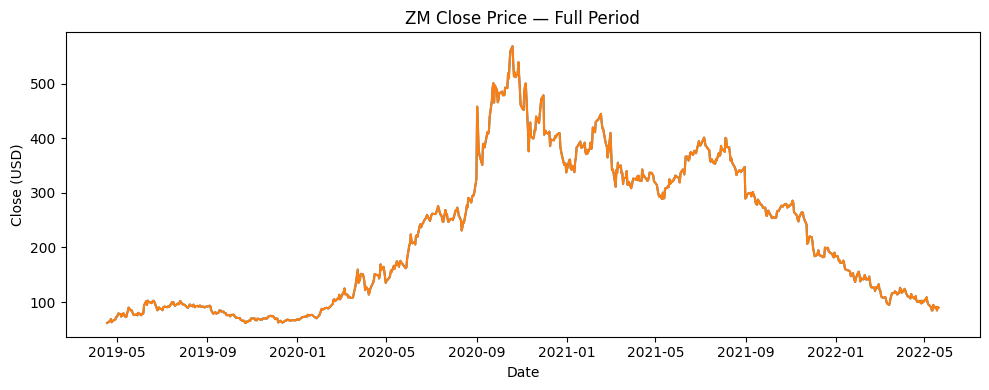

In [3]:

# Load price & earnings data; enforce dtypes and clean columns
assert PRICE_PATH is not None, "Price CSV not found in data/. Expected e.g., data/zm_prices.csv"
assert EARN_PATH is not None, "Earnings CSV not found in data/. Expected e.g., data/zm_earnings.csv"

prices = pd.read_csv(PRICE_PATH)
# Allow common Kaggle column naming variations
# Expected at least: Date, Open, High, Low, Close, Adj Close (optional), Volume
col_map = {c.lower(): c for c in prices.columns}
# Normalize to our preferred case
def std_col(name):
    lower = name.lower().strip()
    if lower == "date": return "Date"
    if lower == "open": return "Open"
    if lower == "high": return "High"
    if lower == "low":  return "Low"
    if lower in ("close","adj close","adj_close"): return "Close" if "Close" in prices.columns else name
    if lower == "adj close": return "Adj Close"
    if lower == "volume": return "Volume"
    return name

prices.columns = [std_col(c) for c in prices.columns]
prices["Date"] = pd.to_datetime(prices["Date"])

# Ensure Close exists; if only Adj Close is available, use it as Close
if "Close" not in prices.columns and "Adj Close" in prices.columns:
    prices["Close"] = prices["Adj Close"]

# Sort and keep only needed columns
keep = [c for c in ["Date","Open","High","Low","Close","Volume"] if c in prices.columns]
prices = prices[keep].sort_values("Date").reset_index(drop=True)

earnings = pd.read_csv(EARN_PATH)
earnings.columns = [c.strip() for c in earnings.columns]
# Normalize earnings columns
rename_map = {}
if "Announcement Date" in earnings.columns: rename_map["Announcement Date"] = "Date"
if "SuprisePct" in earnings.columns: rename_map["SuprisePct"] = "SurprisePct"
earnings = earnings.rename(columns=rename_map)

required_earn_cols = {"Date","EPS_Estimate","EPS_Actual","SurprisePct"}
missing_cols = required_earn_cols - set(earnings.columns)
assert not missing_cols, f"Earnings CSV missing columns: {missing_cols}. Expected: {required_earn_cols}"

earnings["Date"] = pd.to_datetime(earnings["Date"])
earnings = earnings.sort_values("Date").reset_index(drop=True)

# Align earnings dates to the available price range
date_min, date_max = prices["Date"].min(), prices["Date"].max()
earnings = earnings[(earnings["Date"] >= date_min) & (earnings["Date"] <= date_max)].reset_index(drop=True)

print("Prices:", prices.shape, prices["Date"].min().date(), "→", prices["Date"].max().date())
print("Earnings:", earnings.shape, earnings["Date"].min().date() if len(earnings) else None, "→", earnings["Date"].max().date() if len(earnings) else None)

# Show heads for a quick sanity check
display(prices.head(3))
display(earnings.head(3))

# Plot 1: Price over time (basic line)
plt.figure(figsize=(10,4))
plt.plot(prices["Date"], prices["Close"])
plt.title("ZM Close Price — Full Period")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "01_price_full.png")
plt.show()


In [4]:
# --- PATCH: ensure there is exactly ONE 1-D 'Close' column ---

import pandas as pd
from collections import Counter

# 1) If pandas returns a DataFrame for 'Close', collapse to the left-most column
if "Close" in prices.columns:
    col_obj = prices.loc[:, "Close"]  # will be Series if unique, DataFrame if duplicates
    if isinstance(col_obj, pd.DataFrame):
        # Keep the left-most 'Close'
        close_series = col_obj.iloc[:, 0]
        # Drop ALL 'Close' columns and reattach a single Series
        prices = prices.drop(columns=[c for c in prices.columns if c == "Close"])
        prices["Close"] = pd.to_numeric(close_series, errors="coerce")

# 2) If there is no 'Close' but we have 'Adj Close', alias it
elif "Adj Close" in prices.columns:
    prices["Close"] = pd.to_numeric(prices["Adj Close"], errors="coerce")
else:
    raise ValueError("No 'Close' or 'Adj Close' column found. Check your price CSV headers.")

# 3) Optional: de-duplicate any remaining duplicate column names in general
prices = prices.loc[:, ~prices.columns.duplicated()]

# 4) Sanity check
print("Column counts:", Counter(prices.columns))
print("Close dtype:", prices["Close"].dtype)
prices[["Date","Close"]].head(3)


Column counts: Counter({'Date': 1, 'Open': 1, 'High': 1, 'Low': 1, 'Volume': 1, 'Close': 1})
Close dtype: float64


,Date,Close
0,2019-04-18,62.000000
1,2019-04-22,65.699997
2,2019-04-23,69.000000


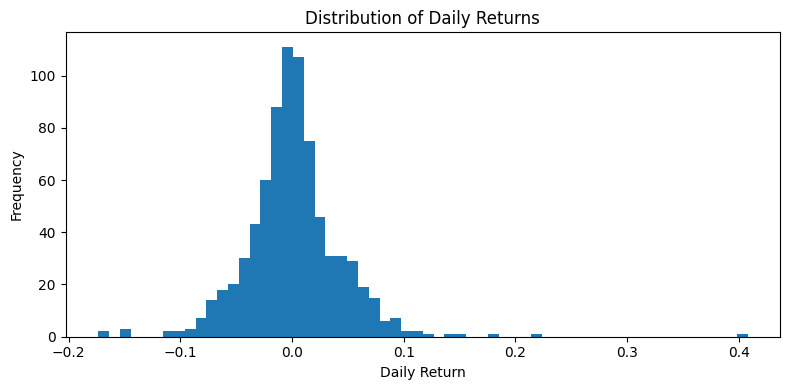

In [5]:

# Compute simple daily returns and rolling volatility (5d & 21d)
prices = prices.sort_values("Date").reset_index(drop=True)
prices["Return"] = prices["Close"].pct_change()
prices["Vol_5d"]  = prices["Return"].rolling(5).std()
prices["Vol_21d"] = prices["Return"].rolling(21).std()

# Quick distribution view of daily returns
plt.figure(figsize=(8,4))
# Avoid seaborn per instruction; use simple histogram
plt.hist(prices["Return"].dropna(), bins=60)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "02_return_distribution.png")
plt.show()


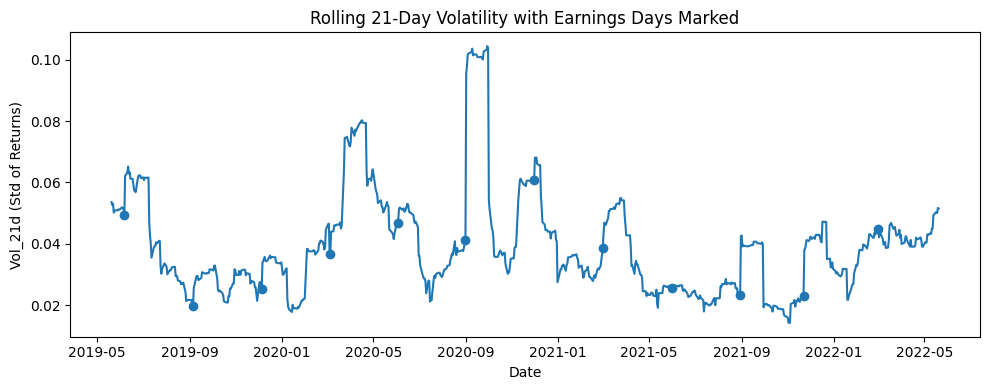

In [6]:

# Flag earnings day and ±window
WINDOW = 5  # days

earn_dates = set(pd.to_datetime(earnings["Date"]).dt.normalize())

def in_window(d, dates, k=WINDOW):
    # d and dates are Timestamps normalized to date resolution
    return any(abs((d - ed).days) <= k for ed in dates)

prices["Date_norm"] = prices["Date"].dt.normalize()
prices["Earnings_Day"] = prices["Date_norm"].isin(earn_dates)
prices["Earnings_Window"] = prices["Date_norm"].apply(lambda d: in_window(d, earn_dates, k=WINDOW))

# Plot 2: Rolling 21d volatility with earnings windows highlighted (as markers on top)
plt.figure(figsize=(10,4))
plt.plot(prices["Date"], prices["Vol_21d"])
# Mark earnings days as vertical markers (using scatter on top)
ed = prices[prices["Earnings_Day"]]
plt.scatter(ed["Date"], ed["Vol_21d"], marker="o")
plt.title("Rolling 21-Day Volatility with Earnings Days Marked")
plt.xlabel("Date"); plt.ylabel("Vol_21d (Std of Returns)")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "03_vol21_with_earnings_days.png")
plt.show()


,avg_return,med_return,std_return,avg_vol21,n
Earnings_Window,,,,,
Normal,0.001551,-0.000879,0.037302,0.038721,693
Earnings_Window,-0.000042,-0.001359,0.074727,0.042679,86


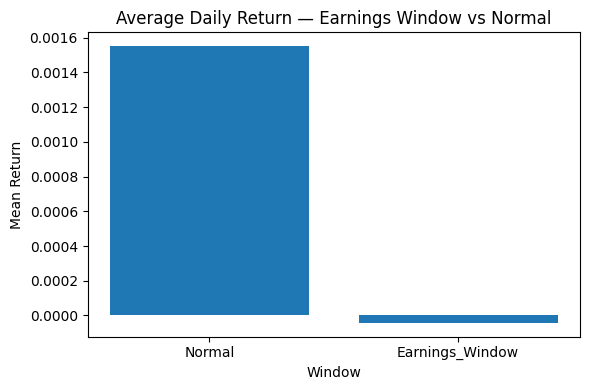

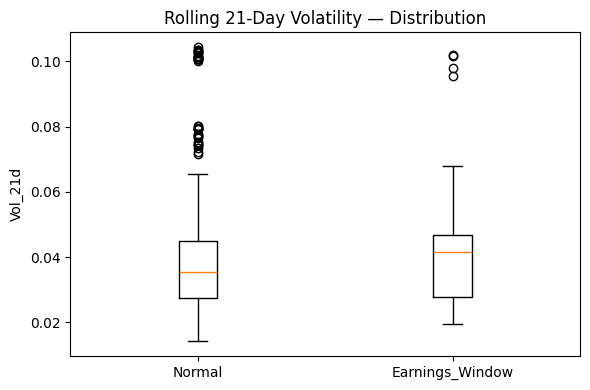

In [7]:

# Compare average daily return & volatility in earnings windows vs normal days
grp = prices.groupby("Earnings_Window").agg(
    avg_return=("Return","mean"),
    med_return=("Return","median"),
    std_return=("Return","std"),
    avg_vol21=("Vol_21d","mean"),
    n=("Return","count")
).rename(index={False:"Normal", True:"Earnings_Window"})
display(grp)

# Bar chart: average daily return by window flag
means = grp["avg_return"]
plt.figure(figsize=(6,4))
plt.bar(means.index.astype(str), means.values)
plt.title("Average Daily Return — Earnings Window vs Normal")
plt.xlabel("Window"); plt.ylabel("Mean Return")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "04_avg_return_bar.png")
plt.show()

# Box chart alternative for Vol_21d
plt.figure(figsize=(6,4))
# Boxplot by boolean flag mapped to integers with labels
data_win = prices.loc[prices["Earnings_Window"], "Vol_21d"].dropna().values
data_norm = prices.loc[~prices["Earnings_Window"], "Vol_21d"].dropna().values
plt.boxplot([data_norm, data_win], tick_labels=["Normal", "Earnings_Window"])
plt.title("Rolling 21-Day Volatility — Distribution")
plt.ylabel("Vol_21d")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "05_vol21_box.png")
plt.show()


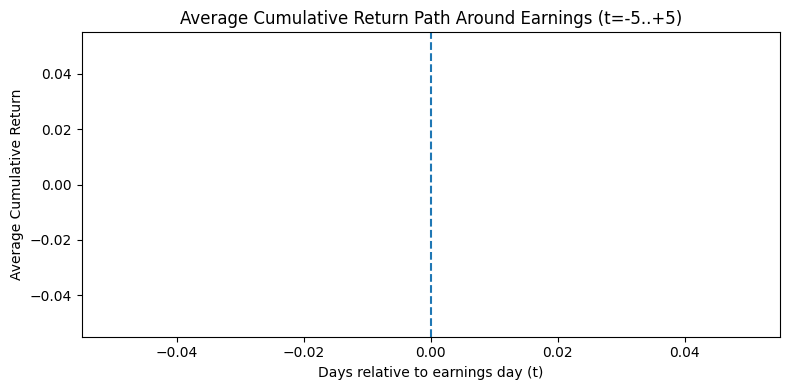

In [8]:

# Event study: Align windows around each earnings day and compute average cumulative returns
window = 5
event_days = prices.loc[prices["Earnings_Day"], "Date_norm"].unique()

# For each event day, build a small dataframe of t = -5..+5 returns and cumulative sums from t=0 base
aligned = []
for eday in event_days:
    mask = (prices["Date_norm"] >= eday - pd.Timedelta(days=window)) & (prices["Date_norm"] <= eday + pd.Timedelta(days=window))
    segment = prices.loc[mask, ["Date","Date_norm","Return"]].copy()
    # t relative to event day
    segment["t"] = (segment["Date_norm"] - eday).dt.days
    # Ensure full range exists
    if set(range(-window, window+1)).issubset(set(segment["t"].tolist())):
        # Compute cumulative return starting at t=0 baseline
        segment = segment.set_index("t").sort_index()
        # Cumulative sum of log(1+r) for numerical stability; then exp-1
        cum = np.cumsum(np.log1p(segment["Return"].fillna(0.0)))
        segment["CumReturn"] = np.exp(cum) - 1.0
        segment["EventDate"] = eday
        aligned.append(segment.reset_index()[["t","CumReturn","EventDate"]])

aligned_df = pd.concat(aligned, ignore_index=True) if aligned else pd.DataFrame(columns=["t","CumReturn","EventDate"])

# Average across events
avg_path = aligned_df.groupby("t")["CumReturn"].mean().reindex(range(-window, window+1))

# Plot: Average cumulative return path
plt.figure(figsize=(8,4))
plt.plot(avg_path.index, avg_path.values)
plt.axvline(0, linestyle="--")
plt.title("Average Cumulative Return Path Around Earnings (t=-5..+5)")
plt.xlabel("Days relative to earnings day (t)")
plt.ylabel("Average Cumulative Return")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "06_event_study_avg_path.png")
plt.show()


In [9]:
from pandas.tseries.offsets import BDay

# Snap each earnings date to the next trading day if it's not already one.
trade_days = set(prices["Date"].dt.normalize())

def snap_to_trading_day(d):
    d = pd.Timestamp(d).normalize()
    while d not in trade_days:
        d += BDay(1)       # move forward to next business day
    return d

earn_snapped = earnings["Date"].apply(snap_to_trading_day)
earn_dates = set(earn_snapped)

# Rebuild flags with snapped dates
prices["Date_norm"] = prices["Date"].dt.normalize()
prices["Earnings_Day"] = prices["Date_norm"].isin(earn_dates)

WINDOW = 5
def in_window(d, dates, k=WINDOW):
    return any(abs((d - ed).days) <= k for ed in dates)

prices["Earnings_Window"] = prices["Date_norm"].apply(lambda d: in_window(d, earn_dates, k=WINDOW))

print("Recount → Day:", int(prices["Earnings_Day"].sum()),
      "Window:", int(prices["Earnings_Window"].sum()))


Recount → Day: 12 Window: 86


In [10]:
# A) sanity on ranges
print("Price range:", prices["Date"].min().date(), "→", prices["Date"].max().date())
print("Earnings range:", earnings["Date"].min().date(), "→", earnings["Date"].max().date())

# B) how many flags did we set?
print("Earnings_Day TRUE:", int(prices["Earnings_Day"].sum()))
print("Earnings_Window TRUE:", int(prices["Earnings_Window"].sum()))

# C) which earnings dates are NOT found in trading calendar?
trade_days = set(prices["Date"].dt.normalize())
missing = sorted(set(earnings["Date"].dt.normalize()) - trade_days)
print("Earnings not matching trading days (first 10):", missing[:10])


Price range: 2019-04-18 → 2022-05-20
Earnings range: 2019-06-06 → 2022-02-28
Earnings_Day TRUE: 12
Earnings_Window TRUE: 86
Earnings not matching trading days (first 10): []


In [11]:

# Optional: Welch's t-test comparing returns during earnings windows vs normal
if HAS_SCIPY:
    r_win = prices.loc[prices["Earnings_Window"], "Return"].dropna()
    r_norm = prices.loc[~prices["Earnings_Window"], "Return"].dropna()
    tstat, pval = stats.ttest_ind(r_win, r_norm, equal_var=False)
    print(f"Welch t-test (Mean returns): t={tstat:.3f}, p={pval:.4f}, N_win={len(r_win)}, N_norm={len(r_norm)}")
else:
    print("scipy not installed — skipping Welch t-test.")

# Optional: OLS of daily return on earnings flags (non-causal; association only)
if HAS_SM:
    df = prices.dropna(subset=["Return"]).copy()
    X = pd.DataFrame({
        "Earnings_Day": df["Earnings_Day"].astype(int),
        "Earnings_Window": df["Earnings_Window"].astype(int)
    })
    X = sm.add_constant(X)
    y = df["Return"]
    model = sm.OLS(y, X).fit()
    print(model.summary())
else:
    print("statsmodels not installed — skipping OLS regression.")


Welch t-test (Mean returns): t=-0.195, p=0.8461, N_win=86, N_norm=693
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.643
Date:                Sat, 13 Sep 2025   Prob (F-statistic):              0.194
Time:                        18:18:36   Log-Likelihood:                 1348.2
No. Observations:                 779   AIC:                            -2690.
Df Residuals:                     776   BIC:                            -2676.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

Wrote Tableau dataset to: /Users/twon/Documents/Zoom_Stock_Analytics/tableau/zm_tableau_dataset.csv


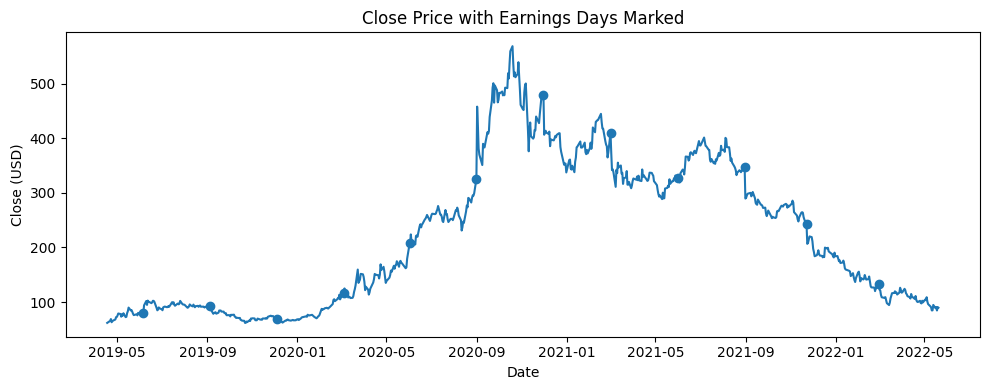

In [12]:

# Save a clean Tableau-ready dataset
tableau_df = prices[["Date","Close","Return","Vol_21d","Earnings_Day","Earnings_Window"]].copy()
tableau_path = TABLEAU_DIR / "zm_tableau_dataset.csv"
tableau_df.to_csv(tableau_path, index=False)
print("Wrote Tableau dataset to:", tableau_path)

# Plot: Final sanity view — Close price with earnings day markers
plt.figure(figsize=(10,4))
plt.plot(prices["Date"], prices["Close"])
ed = prices[prices["Earnings_Day"]]
plt.scatter(ed["Date"], ed["Close"], marker="o")
plt.title("Close Price with Earnings Days Marked")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "07_price_with_markers.png")
plt.show()


=== Executive Snapshot ===
Avg daily return (earnings window): -0.00004
Avg daily return (normal days):     0.00155
Avg 21d volatility (earnings win):  0.04268
Avg 21d volatility (normal days):   0.03872


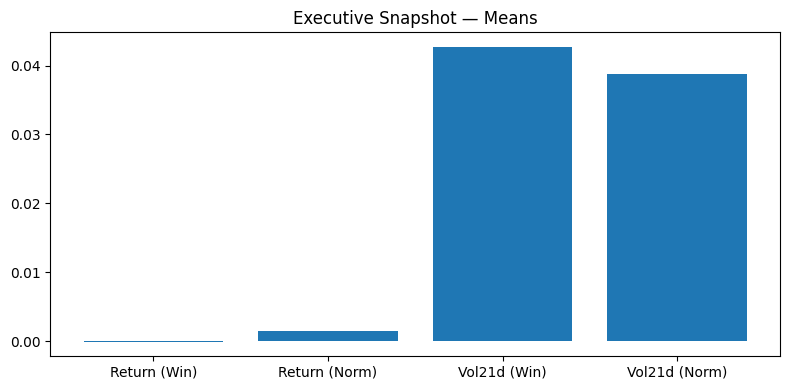

In [13]:

# Executive-style quick summary
summary = {}

# Average returns
r_win = prices.loc[prices["Earnings_Window"], "Return"].dropna()
r_norm = prices.loc[~prices["Earnings_Window"], "Return"].dropna()
summary["avg_return_earnwin"] = r_win.mean() if len(r_win) else np.nan
summary["avg_return_normal"]  = r_norm.mean() if len(r_norm) else np.nan

# Volatility proxy
v_win = prices.loc[prices["Earnings_Window"], "Vol_21d"].dropna()
v_norm = prices.loc[~prices["Earnings_Window"], "Vol_21d"].dropna()
summary["avg_vol21_earnwin"] = v_win.mean() if len(v_win) else np.nan
summary["avg_vol21_normal"]  = v_norm.mean() if len(v_norm) else np.nan

print("=== Executive Snapshot ===")
print(f"Avg daily return (earnings window): {summary['avg_return_earnwin']:.5f}")
print(f"Avg daily return (normal days):     {summary['avg_return_normal']:.5f}")
print(f"Avg 21d volatility (earnings win):  {summary['avg_vol21_earnwin']:.5f}")
print(f"Avg 21d volatility (normal days):   {summary['avg_vol21_normal']:.5f}")

# Bar chart for quick comparison of means
labels = ["Return (Win)","Return (Norm)","Vol21d (Win)","Vol21d (Norm)"]
vals = [
    summary['avg_return_earnwin'],
    summary['avg_return_normal'],
    summary['avg_vol21_earnwin'],
    summary['avg_vol21_normal']
]
plt.figure(figsize=(8,4))
plt.bar(labels, vals)
plt.title("Executive Snapshot — Means")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "08_executive_snapshot.png")
plt.show()
